In [1]:
import tensorflow as tf
import time
import numpy as np
from glob import glob
import unet
import matplotlib.pyplot as plt
import loss_functions
import cv2
import shutil
import os
from IPython.display import clear_output

In [2]:
GT_path = 'binary2\\'
RGBD_path = 'pics2\\'
point_path = 'point_unet2\\'
# GT_path = 'semantic_dataset/'

In [3]:
pic = np.zeros([1,1])
def cross_validation(validnum):
    shutil.rmtree(point_path + 'train')
    shutil.rmtree(point_path + 'test')
    os.mkdir(point_path + 'train')
    os.mkdir(point_path + 'test')
    for i in range(5):
        files = glob(point_path + 'group' + str(i) + '\\*.png')
        if i == validnum:
            for file in files:
                name = list(file.split('\\'))[-1]
                cv2.imwrite(point_path + 'test\\' + name, pic)
        else:
            for file in files:
                name = list(file.split('\\'))[-1][:-4]
                cv2.imwrite(point_path + 'train\\' + name + '.png', pic)
                cv2.imwrite(point_path + 'train\\' + name + '_0.png', pic)
                cv2.imwrite(point_path + 'train\\' + name + '_1.png', pic)
                cv2.imwrite(point_path + 'train\\' + name + '_2.png', pic)

In [4]:
validnum = 4
cross_validation(validnum)

In [5]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
BATCH_SIZE = 8
BUFFER_SIZE = 500
# STEPS_PER_EPOCH = 420 // BATCH_SIZE

In [6]:
def load(point_file):
    name = tf.strings.split(point_file,'\\')[-1]
    GT = tf.io.read_file(GT_path + name)
    RGBD = tf.io.read_file(RGBD_path + name)
    GT = tf.image.decode_png(GT)
    RGBD = tf.image.decode_png(RGBD)

    GT = tf.cast(GT, tf.float32)// 255.0
    RGBD = tf.cast(RGBD, tf.float32)/ 255.0

    return RGBD, GT

In [7]:
# load('point_folder/train/D_16-12-31.png')

In [8]:
train = tf.data.Dataset.list_files(point_path+'train\\*.png')
train = train.map(load,num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)#.repeat()

In [9]:
test = tf.data.Dataset.list_files(point_path+'test\\*.png')
test = test.map(load)
test_dataset = test.batch(BATCH_SIZE)

In [10]:
# def display(display_list):
#   plt.figure(figsize=(15, 15))

#   title = ['Input Image', 'True Mask', 'Predicted Mask']

#   for i in range(len(display_list)):
#     plt.subplot(1, len(display_list), i+1)
#     plt.title(title[i])
#     plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
#     plt.axis('off')
#   plt.show()

In [11]:
# import numpy as np
# for image, mask in train.take(1):
# #     print(image.shape, mask.shape)
#     sample_image, sample_mask = image, mask
# # print(np.unique(sample_mask[:,:,:3].numpy().flatten()))
# display([sample_image[:,:,:3], sample_mask[:,:,:3]])

In [12]:
# david version 
model = unet.UResNet34(input_shape=(256,256,3), classes=1, encoder_weights=None) #semantic segmentatnion change class

In [13]:
# model.summary()

In [14]:
opt = tf.keras.optimizers.Adam(learning_rate=0.000001)
model.compile(optimizer=opt,#'adam'
#               loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),)
              loss = loss_functions.weighted_dice_loss,)
#               metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.MeanIoU(num_classes=2)])#semantic segmentatnion change class

In [15]:
checkpoint_filepath = 'weights_checkpoints/2_0'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [16]:
# def show_predictions(dataset=None, num=1):
#   if dataset:
#     for image, mask in dataset.take(num):
#       pred_mask = model.predict(image)
#       display([image[0], mask[0], pred_mask.reshape([256,256,3])*255.0])#255.0 was create_mask
#   else:
#     display([sample_image[:,:,:3], sample_mask,
#              model.predict(sample_image[tf.newaxis, ...])[:,:,:,0].reshape([256,256,1])*255.0])# for instance segmentatnion
# #     display([sample_image[:,:,:3], tf.reshape(sample_mask[:,:,0], [256,256,1]),
# #              model.predict(sample_image[tf.newaxis, ...])[:,:,:,0].reshape([256,256,1])])# only use this

In [17]:
# show_predictions()

In [18]:
# class DisplayCallback(tf.keras.callbacks.Callback):
#   def on_epoch_end(self, epoch, logs=None):
#     clear_output(wait=True)
#     show_predictions()
#     print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [19]:
EPOCHS = 30
# VALIDATION_STEPS = 105//BATCH_SIZE
model_history = model.fit(train_dataset, epochs=EPOCHS,
#                           steps_per_epoch=STEPS_PER_EPOCH,
#                           validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[model_checkpoint_callback])

Epoch 1/30
57/57 [==============================] - 11s 75ms/step - loss: 0.8821 - val_loss: 0.8691
Epoch 2/30
57/57 [==============================] - 4s 61ms/step - loss: 0.8779 - val_loss: 0.8690
Epoch 3/30
57/57 [==============================] - 4s 61ms/step - loss: 0.8734 - val_loss: 0.8691
Epoch 4/30
57/57 [==============================] - 4s 61ms/step - loss: 0.8654 - val_loss: 0.8601
Epoch 5/30
57/57 [==============================] - 4s 61ms/step - loss: 0.8599 - val_loss: 0.8562
Epoch 6/30
57/57 [==============================] - 4s 61ms/step - loss: 0.8515 - val_loss: 0.8544
Epoch 7/30
57/57 [==============================] - 4s 61ms/step - loss: 0.8431 - val_loss: 0.8359
Epoch 8/30
57/57 [==============================] - 4s 61ms/step - loss: 0.8312 - val_loss: 0.8007
Epoch 9/30
57/57 [==============================] - 4s 61ms/step - loss: 0.7933 - val_loss: 0.7517
Epoch 10/30
57/57 [==============================] - 4s 61ms/step - loss: 0.6821 - val_loss: 0.6102
Epoch 11

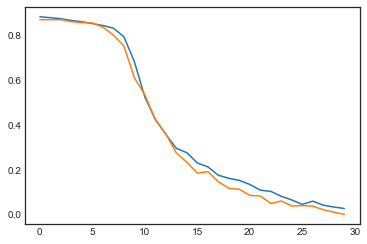

In [20]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)

In [21]:
model.load_weights(checkpoint_filepath)

In [22]:
def save_predictions(path):
    files = glob(path + '*.png')
    for file in files:
        name = list(file.split("\\"))[-1]
#         print(name)
        image, _ = load(file)
        prediction = model.predict(tf.reshape(image,[1, 256, 256, 3]))#change here when change input shape
#         print(prediction.shape)
        prediction = np.array(tf.reshape(prediction[:,:,:,0], [256,256,1]))*255
        cv2.imwrite('predictions_unet\\' + name, prediction)#这个是正在用的
#         cv2.imwrite('Unet_cross_results/' + name, prediction[:,:,1:])

In [23]:
# start = time.time()
save_predictions(point_path + 'test\\')
# end = time.time()
# print(end - start)


In [24]:
# files = glob(point_path + 'test/' + '*.png')
# (end - start)/len(files)